In [1]:
!pip install fastai2
!pip install gdown
from fastai2.data.external import untar_data,URLs
from fastai2.data.transforms import get_image_files
from fastai2.vision.all import *

     |████████████████████████████████| 194kB 6.8MB/s 


# Preparing Data
Creating the dataloaders. Dataloaders in fastai are just a wrapper that contains a traing and a validation Dataloader.

In [2]:
!gdown https://drive.google.com/uc?id=1E7YOlwok4ENUrA4mP35GzGnIS6mP1xB8
!unzip att_face_dataset.zip -d train_images

Downloading...
From: https://drive.google.com/uc?id=1E7YOlwok4ENUrA4mP35GzGnIS6mP1xB8
To: /content/att_face_dataset.zip
3.78MB [00:00, 59.9MB/s]
Archive:  att_face_dataset.zip
  inflating: train_images/README     
  inflating: train_images/s1/1.pgm   
  inflating: train_images/s1/10.pgm  
  inflating: train_images/s1/2.pgm   
  inflating: train_images/s1/3.pgm   
  inflating: train_images/s1/4.pgm   
  inflating: train_images/s1/5.pgm   
  inflating: train_images/s1/6.pgm   
  inflating: train_images/s1/7.pgm   
  inflating: train_images/s1/8.pgm   
  inflating: train_images/s1/9.pgm   
  inflating: train_images/s10/1.pgm  
  inflating: train_images/s10/10.pgm  
  inflating: train_images/s10/2.pgm  
  inflating: train_images/s10/3.pgm  
  inflating: train_images/s10/4.pgm  
  inflating: train_images/s10/5.pgm  
  inflating: train_images/s10/6.pgm  
  inflating: train_images/s10/7.pgm  
  inflating: train_images/s10/8.pgm  
  inflating: train_images/s10/9.pgm  
  inflating: train_images

In [3]:
!gdown https://drive.google.com/uc?id=1A3fuK50ukiYN_CI9k6GHHr45OtcSq9vT
!unzip test_images.zip

Downloading...
From: https://drive.google.com/uc?id=1A3fuK50ukiYN_CI9k6GHHr45OtcSq9vT
To: /content/test_images.zip
3.82MB [00:00, 122MB/s]
Archive:  test_images.zip
   creating: test_images/
  inflating: test_images/.DS_Store   
  inflating: __MACOSX/test_images/._.DS_Store  
   creating: test_images/h/
   creating: test_images/b/
  inflating: test_images/h/9.jpg     
  inflating: __MACOSX/test_images/h/._9.jpg  
  inflating: test_images/h/5.jpg     
  inflating: __MACOSX/test_images/h/._5.jpg  
  inflating: test_images/h/7.jpg     
  inflating: __MACOSX/test_images/h/._7.jpg  
  inflating: test_images/h/2.jpg     
  inflating: __MACOSX/test_images/h/._2.jpg  
  inflating: test_images/h/3.jpg     
  inflating: __MACOSX/test_images/h/._3.jpg  
  inflating: test_images/b/8.jpg     
  inflating: __MACOSX/test_images/b/._8.jpg  
  inflating: test_images/b/10.jpg    
  inflating: __MACOSX/test_images/b/._10.jpg  
  inflating: test_images/b/4.jpg     
  inflating: __MACOSX/test_images/b/._4.

In [4]:
path = Path()
files = get_image_files(path/"train_images")
files[0]

Path('train_images/s40/1.pgm')

In [5]:
len(files)

400

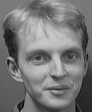

In [6]:
import PIL
img = PIL.Image.open(files[0])
img

In [7]:
import re
def label_func(fname):
    #return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]
    return parent_label(fname)

label_func(files[0])

's40'

In [8]:
labels = list(set(files.map(label_func)))
len(labels)

40

In [9]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

# Using a Custom Data Block

In [10]:
class ImageTuple(Tuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [11]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai2.torch_core.TensorImage, fastai2.torch_core.TensorImage)

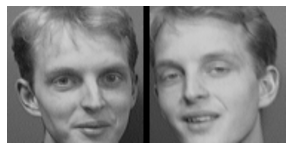

In [12]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [13]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, 
                                             batch_tfms=IntToFloatTensor,
                                            )

In [14]:
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls)) 
    return random.choice(lbl2files[cls]),same

In [15]:
def get_tuple_files(path):
    files = get_image_files(path=path)
    return [[f, *draw_other(f)] for f in files]

In [16]:
def get_x(t): return t[:2]
def get_y(t): return t[2]

In [17]:
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuple_files,
    get_x=get_x, get_y=get_y,
    splitter=RandomSplitter(),
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats), Rotate, Flip, Warp, Zoom, Contrast, Dihedral]
)
siamese.summary(path/"train_images")

Setting-up type transforms pipelines
Found 400 items
2 datasets of sizes 320,80
Setting up Pipeline: get_x -> ImageTuple.create
Setting up Pipeline: get_y -> Categorize

Building one sample
  Pipeline: get_x -> ImageTuple.create
    starting from
      [train_images/s37/5.pgm, train_images/s37/10.pgm, True]
    applying get_x gives
      [train_images/s37/5.pgm, train_images/s37/10.pgm]
    applying ImageTuple.create gives
      (PILImage mode=RGB size=92x112, PILImage mode=RGB size=92x112)
  Pipeline: get_y -> Categorize
    starting from
      [train_images/s37/5.pgm, train_images/s37/10.pgm, True]
    applying get_y gives
      True
    applying Categorize gives
      TensorCategory(1)

Final sample: ((PILImage mode=RGB size=92x112, PILImage mode=RGB size=92x112), TensorCategory(1))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: Rotate -> Flip -> Warp -> Zoom -> Contrast -> Dihedral -> IntToFloatTensor -> N

In [18]:
dls = siamese.dataloaders(path/"train_images", path=path)

In [19]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageTuple: [fastai2.vision.augment.AffineCoordTfm,
    fastai2.vision.augment.AffineCoordTfm]},
  fastai2.vision.augment.AffineCoordTfm]}

In [20]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [21]:
b = dls.one_batch()

In [22]:
dls.show_batch()

RecursionError: ignored

In [ ]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)


In [ ]:
??dls.test_dl()

# Using the Mid-Level API

##Preparing the Data

In [100]:
from fastai2.vision.all import *

In [101]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [102]:
files = get_image_files(path/"train_images")
test_files = get_image_files(path/'test_images')

In [103]:
labels = list(set(files.map(label_func)))
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

In [104]:
import random
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [105]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

In [106]:
len(train_files), len(valid_files), len(test_files)

(320, 80, 10)

In [107]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

In [108]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)

In [109]:
b = dls.one_batch()

In [110]:
dls = dls.cuda()

## Using the Mid-Level API

In [75]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (TensorImage(img1), TensorImage(img2), torch.Tensor([same]).squeeze())
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [76]:
train_tl= TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [77]:
dls = DataLoaders.from_dsets(train_tl, valid_tl
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()

In [78]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [79]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(lbl2files[cls]),same

In [80]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)

In [81]:
tls = TfmdLists(files, tfm, splits=splits)

In [82]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [83]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [84]:
b = dls.one_batch()

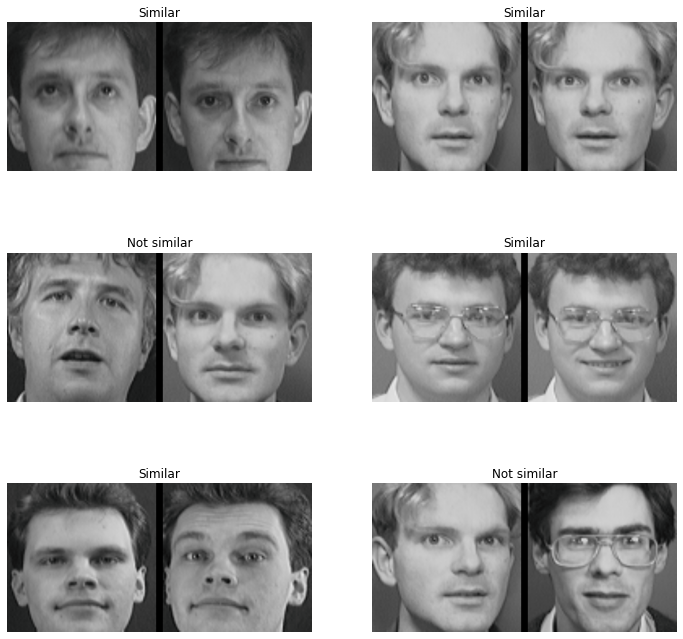

In [85]:
dls.show_batch()

# Train the Model

In [111]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [112]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai2.vision.learner._resnet_split>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [113]:
encoder = create_body(resnet34, cut=-2)

In [114]:
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [115]:
head = create_head(512*4, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [116]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [117]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [118]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [119]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(t))
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(lbl2files[cls]),same

In [120]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [121]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

In [122]:
learn.freeze()

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=1.3182567499825382e-06)

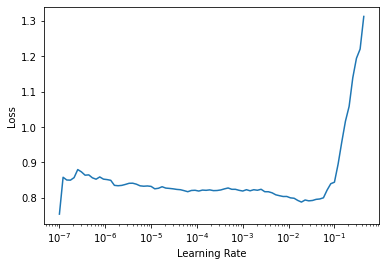

In [123]:
learn.lr_find()

In [124]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.888079,0.747487,0.500000,00:06
1,0.866092,0.966936,0.512500,00:05
2,0.922443,1.135756,0.475000,00:05
3,0.871285,0.842064,0.587500,00:05
4,0.822032,0.638578,0.637500,00:05
5,0.778089,0.595322,0.737500,00:05
6,0.747413,0.541253,0.762500,00:05
7,0.715661,0.522274,0.750000,00:05
8,0.688656,0.509958,0.737500,00:05
9,0.663257,0.506263,0.750000,00:05


In [125]:
learn.save('stage1-10e-3e-3')

In [126]:
learn.unfreeze()

In [127]:
learn.fit_one_cycle(20, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.560891,0.507625,0.750000,00:08
1,0.563813,0.505646,0.762500,00:07
2,0.559278,0.500976,0.762500,00:07
3,0.566282,0.495946,0.762500,00:07
4,0.549910,0.489664,0.762500,00:07
5,0.548850,0.486725,0.775000,00:07
6,0.546683,0.476888,0.762500,00:07
7,0.535522,0.470956,0.787500,00:07
8,0.538471,0.468758,0.787500,00:07
9,0.536325,0.465803,0.787500,00:07


In [128]:
learn.save('stage2-unfreeze-20epochs-slice(1e-6,1e-4)')

In [129]:
learn.export('siamese-face-unfreezed.pkl')

In [151]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

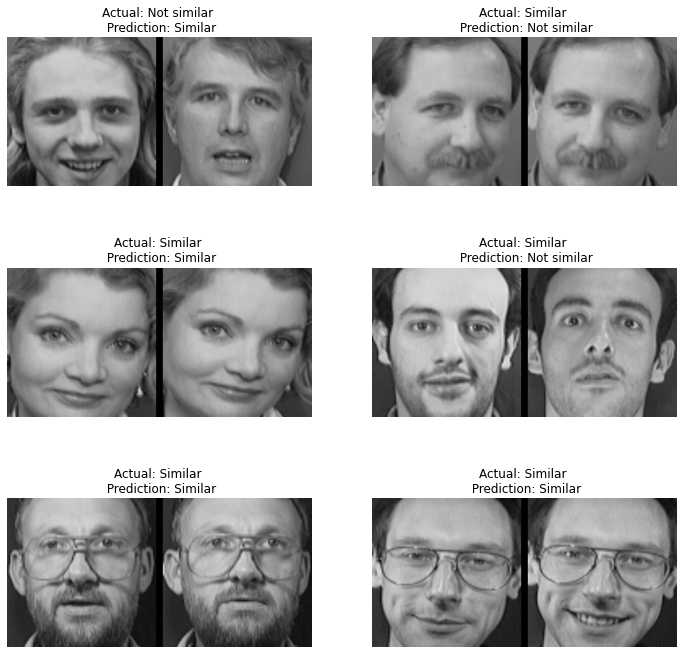

In [152]:
learn.show_results()

In [130]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

In [131]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    print(res)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

In [154]:
tensor(0)

tensor(0)

In [132]:
test_img_paths = get_image_files(('/content/test_images'))
test_img_paths

(#10) [Path('/content/test_images/h/9.jpg'),Path('/content/test_images/h/7.jpg'),Path('/content/test_images/h/3.jpg'),Path('/content/test_images/h/2.jpg'),Path('/content/test_images/h/5.jpg'),Path('/content/test_images/b/4.jpg'),Path('/content/test_images/b/10.jpg'),Path('/content/test_images/b/6.jpg'),Path('/content/test_images/b/8.jpg'),Path('/content/test_images/b/1.jpg')]

In [141]:
PILImage.create??

In [155]:
def create_random_tests(filenames):
    file1 = random.choice(test_img_paths)
    file2 = random.choice(test_img_paths)
    same = True if file1 == file2 else False
    return PILImage.create(file1), PILImage.create(file2), same

(tensor(1), tensor(1), tensor([0.4906, 0.5094]))


(tensor(1), tensor(1), tensor([0.2688, 0.7312]))


(tensor(0), tensor(0), tensor([0.5415, 0.4585]))


(tensor(0), tensor(0), tensor([0.5024, 0.4976]))


(tensor(1), tensor(1), tensor([0.3768, 0.6232]))


(tensor(0), tensor(0), tensor([0.5197, 0.4803]))


(tensor(0), tensor(0), tensor([0.6560, 0.3440]))


(tensor(1), tensor(1), tensor([0.3054, 0.6946]))


(tensor(0), tensor(0), tensor([0.5747, 0.4253]))


(tensor(0), tensor(0), tensor([0.6388, 0.3612]))
correct:  6  -->  0.6


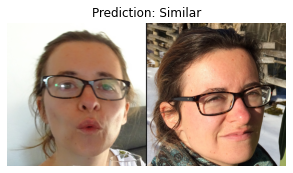

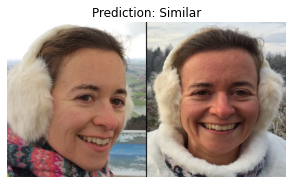

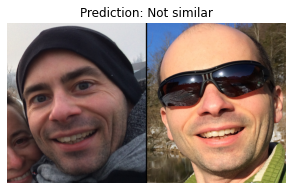

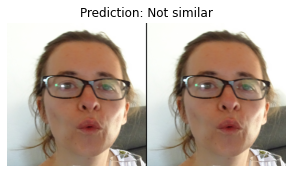

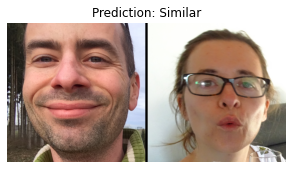

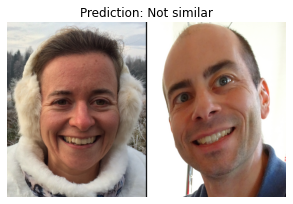

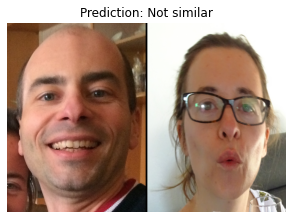

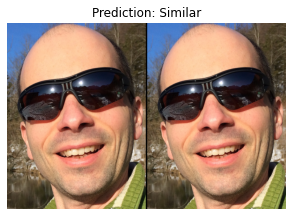

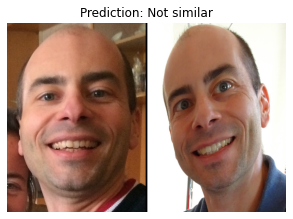

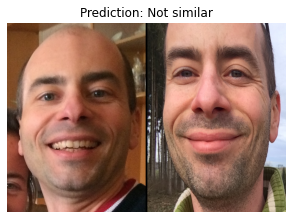

In [160]:
correct = 0
for i in range(10):
    imgtest, imgval, same = create_random_tests(test_img_paths)
    siamtest = SiameseImage(imgval, imgtest)    
    res = learn.siampredict(siamtest)
    #print(res[2])
    if  res[0] == tensor(0) and not same:
        correct += 1
    if  res[0] == tensor(1) and same:
        correct += 1
print("correct: ", correct, " --> ", correct/10)

